# Import Contour Data

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ACS=Dataset('META3.1exp_DT_allsat_Anticyclonic_short_19930101_20200307.nc')

In [3]:
ACL=Dataset('META3.1exp_DT_allsat_Anticyclonic_long_19930101_20200307.nc')

In [4]:
print(ACS.variables.keys())

dict_keys(['amplitude', 'cost_association', 'effective_area', 'effective_contour_height', 'effective_contour_latitude', 'effective_contour_longitude', 'effective_contour_shape_error', 'effective_radius', 'inner_contour_height', 'latitude', 'latitude_max', 'longitude', 'longitude_max', 'num_contours', 'num_point_e', 'num_point_s', 'observation_flag', 'observation_number', 'speed_area', 'speed_average', 'speed_contour_height', 'speed_contour_latitude', 'speed_contour_longitude', 'speed_contour_shape_error', 'speed_radius', 'time', 'track', 'uavg_profile'])


# Import ADT Data

In [5]:
SLA=Dataset('../copernicus/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1704119807053.nc')

In [6]:
print(SLA.variables.keys())

dict_keys(['adt', 'crs', 'latitude', 'time', 'longitude'])


In [7]:
adt=SLA.variables['adt'][:]

In [8]:
adt.shape

(3653, 81, 181)

In [9]:
maplat=SLA.variables['latitude'][:]
maplon=SLA.variables['longitude'][:]

In [10]:
maplat

masked_array(data=[24.875, 25.125, 25.375, 25.625, 25.875, 26.125, 26.375,
                   26.625, 26.875, 27.125, 27.375, 27.625, 27.875, 28.125,
                   28.375, 28.625, 28.875, 29.125, 29.375, 29.625, 29.875,
                   30.125, 30.375, 30.625, 30.875, 31.125, 31.375, 31.625,
                   31.875, 32.125, 32.375, 32.625, 32.875, 33.125, 33.375,
                   33.625, 33.875, 34.125, 34.375, 34.625, 34.875, 35.125,
                   35.375, 35.625, 35.875, 36.125, 36.375, 36.625, 36.875,
                   37.125, 37.375, 37.625, 37.875, 38.125, 38.375, 38.625,
                   38.875, 39.125, 39.375, 39.625, 39.875, 40.125, 40.375,
                   40.625, 40.875, 41.125, 41.375, 41.625, 41.875, 42.125,
                   42.375, 42.625, 42.875, 43.125, 43.375, 43.625, 43.875,
                   44.125, 44.375, 44.625, 44.875],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [11]:
maplon

masked_array(data=[134.875, 135.125, 135.375, 135.625, 135.875, 136.125,
                   136.375, 136.625, 136.875, 137.125, 137.375, 137.625,
                   137.875, 138.125, 138.375, 138.625, 138.875, 139.125,
                   139.375, 139.625, 139.875, 140.125, 140.375, 140.625,
                   140.875, 141.125, 141.375, 141.625, 141.875, 142.125,
                   142.375, 142.625, 142.875, 143.125, 143.375, 143.625,
                   143.875, 144.125, 144.375, 144.625, 144.875, 145.125,
                   145.375, 145.625, 145.875, 146.125, 146.375, 146.625,
                   146.875, 147.125, 147.375, 147.625, 147.875, 148.125,
                   148.375, 148.625, 148.875, 149.125, 149.375, 149.625,
                   149.875, 150.125, 150.375, 150.625, 150.875, 151.125,
                   151.375, 151.625, 151.875, 152.125, 152.375, 152.625,
                   152.875, 153.125, 153.375, 153.625, 153.875, 154.125,
                   154.375, 154.625, 154.875, 155.1

# Calculate Time Range

In [12]:
time=ACS.variables['time'][:]

In [13]:
import datetime

In [14]:
datetime.datetime.strptime('1950-01-01','%Y-%m-%d')+datetime.timedelta(days=25633)

datetime.datetime(2020, 3, 7, 0, 0)

In [15]:
datetime.datetime.strptime('2010-01-01','%Y-%m-%d')-datetime.datetime.strptime('1950-01-01','%Y-%m-%d')

datetime.timedelta(days=21915)

Time from 2010-1-1 to 2020-1-1 should be 21915 to 25567.

# Try Data Transform

通过涡旋中心坐标与时间筛选某一天的涡旋边界数据

In [82]:
center_lon=ACS.variables['longitude'][:]
center_lat=ACS.variables['latitude'][:]

In [96]:
contour_lon=ACS.variables['effective_contour_longitude'][(time==21915)&(center_lat>=24.875)&(center_lat<=44.875)&(center_lon>=134.875)&(center_lon<=179.875)]

In [97]:
contour_lat=ACS.variables['effective_contour_latitude'][(time==21915)&(center_lat>=24.875)&(center_lat<=44.875)&(center_lon>=134.875)&(center_lon<=179.875)]

In [98]:
contour_lon.shape

(1, 50)

将其映射到哥白尼数据中的坐标

In [99]:
def point_in_polygon(x, y, poly_x, poly_y):    #判断grid坐标是否位于涡旋边界内部
    num_vertices = len(poly_x)
    inside = False
    j = num_vertices - 1
    for i in range(num_vertices):
        if ((poly_y[i] > y) != (poly_y[j] > y)) and (x < (poly_x[j] - poly_x[i]) * (y - poly_y[i]) / (poly_y[j] - poly_y[i]) + poly_x[i]):
            inside = not inside
        j = i
    return inside

In [170]:
grid_data = np.zeros((len(maplat), len(maplon)))
for i in range(len(maplat)):
    for j in range(len(maplon)):
        if point_in_polygon(maplon[j], maplat[i], contour_lon[0], contour_lat[0]):
            grid_data[i, j] = 1

(34.9, 35.9)

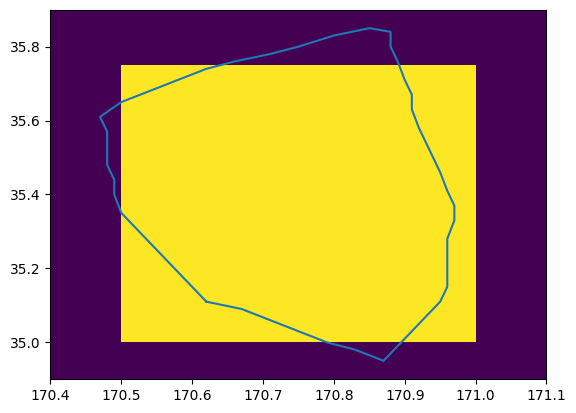

In [161]:
plt.pcolormesh(maplon,maplat,grid_data)
plt.plot(contour_lon.T,contour_lat.T)
plt.xlim(170.4,171.1)
plt.ylim(34.9,35.9)

# Data Transform

## Get Contour Coordinate within Northwest Pacific Area

In [16]:
time_acs=ACS.variables['time'][:]
center_lon_acs=ACS.variables['longitude'][:]
center_lat_acs=ACS.variables['latitude'][:]

In [17]:
time_acl=ACL.variables['time'][:]
center_lon_acl=ACL.variables['longitude'][:]
center_lat_acl=ACL.variables['latitude'][:]

In [18]:
import time as tm

In [124]:
contour_coordinate_acs=[]
contour_time_acs=[]
contour_index_acs=[]

start_time=tm.time()
for i in range(len(time_acs)):
    if (center_lat_acs[i]>=24.875)&(center_lat_acs[i]<=44.875)&(center_lon_acs[i]>=134.875)&(center_lon_acs[i]<=179.875):
        contour_coordinate_acs.append([ACS.variables['effective_contour_longitude'][i],ACS.variables['effective_contour_latitude'][i]])
        contour_time_acs.append(time_acs[i])
        contour_index_acs.append(i)
    if i%1e5==0 or i==len(time_acs)-1:
        end_time=tm.time()
        elapsed_time=end_time-start_time
        print(f"{i}/{len(time_acs)}, 进度:{i/len(time_acs)*100:.2f}%, 经过{elapsed_time:.2f}s")

0/2471187, 进度:0.00%, 经过0.00s
100000/2471187, 进度:4.05%, 经过1.89s
200000/2471187, 进度:8.09%, 经过3.60s
300000/2471187, 进度:12.14%, 经过5.38s
400000/2471187, 进度:16.19%, 经过7.12s
500000/2471187, 进度:20.23%, 经过8.83s
600000/2471187, 进度:24.28%, 经过10.59s
700000/2471187, 进度:28.33%, 经过12.35s
800000/2471187, 进度:32.37%, 经过14.16s
900000/2471187, 进度:36.42%, 经过15.97s
1000000/2471187, 进度:40.47%, 经过17.60s
1100000/2471187, 进度:44.51%, 经过19.29s
1200000/2471187, 进度:48.56%, 经过21.02s
1300000/2471187, 进度:52.61%, 经过22.75s
1400000/2471187, 进度:56.65%, 经过24.48s
1500000/2471187, 进度:60.70%, 经过26.23s
1600000/2471187, 进度:64.75%, 经过27.90s
1700000/2471187, 进度:68.79%, 经过29.60s
1800000/2471187, 进度:72.84%, 经过31.34s
1900000/2471187, 进度:76.89%, 经过33.15s
2000000/2471187, 进度:80.93%, 经过34.82s
2100000/2471187, 进度:84.98%, 经过36.52s
2200000/2471187, 进度:89.03%, 经过38.20s
2300000/2471187, 进度:93.07%, 经过39.88s
2400000/2471187, 进度:97.12%, 经过41.59s
2471186/2471187, 进度:100.00%, 经过42.82s


In [128]:
contour_coordinate_acl=[]
contour_time_acl=[]
contour_index_acl=[]

start_time=tm.time()
for i in range(len(time_acl)):
    if (center_lat_acl[i]>=24.875)&(center_lat_acl[i]<=44.875)&(center_lon_acl[i]>=134.875)&(center_lon_acl[i]<=179.875):
        contour_coordinate_acl.append([ACL.variables['effective_contour_longitude'][i],ACL.variables['effective_contour_latitude'][i]])
        contour_time_acl.append(time_acl[i])
        contour_index_acl.append(i)
    if i%1e5==0 or i==len(time_acl)-1:
        end_time=tm.time()
        elapsed_time=end_time-start_time
        print(f"{i}/{len(time_acl)}, 进度:{i/len(time_acl)*100:.2f}%, 经过{elapsed_time:.2f}s")

0/32054678, 进度:0.00%, 经过0.00s
100000/32054678, 进度:0.31%, 经过1.89s
200000/32054678, 进度:0.62%, 经过4.05s
300000/32054678, 进度:0.94%, 经过6.28s
400000/32054678, 进度:1.25%, 经过8.44s
500000/32054678, 进度:1.56%, 经过10.61s
600000/32054678, 进度:1.87%, 经过12.45s
700000/32054678, 进度:2.18%, 经过14.77s
800000/32054678, 进度:2.50%, 经过16.65s
900000/32054678, 进度:2.81%, 经过18.59s
1000000/32054678, 进度:3.12%, 经过20.14s
1100000/32054678, 进度:3.43%, 经过22.03s
1200000/32054678, 进度:3.74%, 经过24.21s
1300000/32054678, 进度:4.06%, 经过26.23s
1400000/32054678, 进度:4.37%, 经过28.26s
1500000/32054678, 进度:4.68%, 经过30.33s
1600000/32054678, 进度:4.99%, 经过32.85s
1700000/32054678, 进度:5.30%, 经过34.83s
1800000/32054678, 进度:5.62%, 经过36.98s
1900000/32054678, 进度:5.93%, 经过39.03s
2000000/32054678, 进度:6.24%, 经过41.02s
2100000/32054678, 进度:6.55%, 经过42.77s
2200000/32054678, 进度:6.86%, 经过45.03s
2300000/32054678, 进度:7.18%, 经过47.89s
2400000/32054678, 进度:7.49%, 经过49.85s
2500000/32054678, 进度:7.80%, 经过51.60s
2600000/32054678, 进度:8.11%, 经过53.47s
2700000/32054678, 进度:

21000000/32054678, 进度:65.51%, 经过442.37s
21100000/32054678, 进度:65.83%, 经过444.38s
21200000/32054678, 进度:66.14%, 经过446.33s
21300000/32054678, 进度:66.45%, 经过448.41s
21400000/32054678, 进度:66.76%, 经过450.46s
21500000/32054678, 进度:67.07%, 经过452.48s
21600000/32054678, 进度:67.38%, 经过454.72s
21700000/32054678, 进度:67.70%, 经过456.78s
21800000/32054678, 进度:68.01%, 经过458.55s
21900000/32054678, 进度:68.32%, 经过460.95s
22000000/32054678, 进度:68.63%, 经过462.69s
22100000/32054678, 进度:68.94%, 经过464.64s
22200000/32054678, 进度:69.26%, 经过466.37s
22300000/32054678, 进度:69.57%, 经过468.33s
22400000/32054678, 进度:69.88%, 经过470.24s
22500000/32054678, 进度:70.19%, 经过472.16s
22600000/32054678, 进度:70.50%, 经过474.08s
22700000/32054678, 进度:70.82%, 经过476.35s
22800000/32054678, 进度:71.13%, 经过478.62s
22900000/32054678, 进度:71.44%, 经过480.71s
23000000/32054678, 进度:71.75%, 经过482.68s
23100000/32054678, 进度:72.06%, 经过484.73s
23200000/32054678, 进度:72.38%, 经过487.01s
23300000/32054678, 进度:72.69%, 经过489.24s
23400000/32054678, 进度:73.00%, 经过491.38s


In [127]:
np.save('contour_coordinate_acs',contour_coordinate_acs)
np.save('contour_time_acs',contour_time_acs)
np.save('contour_index_acs',contour_index_acs)

In [129]:
np.save('contour_coordinate_acl',contour_coordinate_acl)
np.save('contour_time_acl',contour_time_acl)
np.save('contour_index_acl',contour_index_acl)

保存为：

contour_coordinate:顶点的坐标，格式为[[50个lon],[50个lat]],即list中每个元素shape均为(2,50)

contour_time:顶点坐标获取的时间

contour_index:顶点坐标在原始数据中对应的序号

[[170.62 170.67 170.71 170.75 170.79 170.83 170.87 170.89 170.91 170.93
  170.95 170.96 170.96 170.96 170.96 170.97 170.97 170.96 170.95 170.94
  170.93 170.92 170.91 170.91 170.9  170.89 170.88 170.88 170.85 170.8
  170.75 170.71 170.66 170.62 170.58 170.54 170.5  170.47 170.48 170.48
  170.48 170.49 170.49 170.5  170.52 170.54 170.56 170.58 170.6  170.62]
 [ 35.11  35.09  35.06  35.03  35.    34.98  34.95  34.99  35.03  35.07
   35.11  35.15  35.2   35.24  35.28  35.33  35.37  35.41  35.46  35.5
   35.54  35.58  35.63  35.67  35.71  35.76  35.8   35.84  35.85  35.83
   35.8   35.78  35.76  35.74  35.71  35.68  35.65  35.61  35.57  35.53
   35.48  35.44  35.4   35.35  35.31  35.27  35.23  35.19  35.15  35.11]]
25585


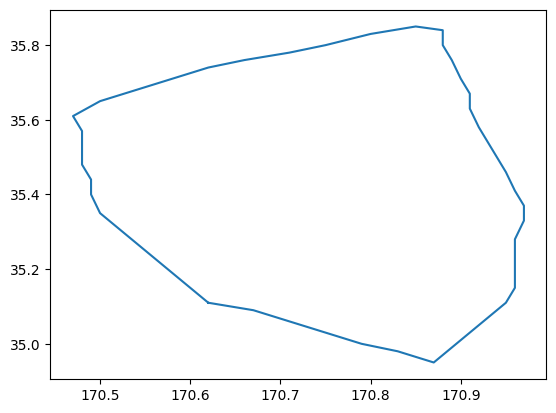

In [159]:
for i in range(len(contour_coordinate_acs)):
    if contour_time_acs[i]==21915:
        print(contour_coordinate_acs[i])
        print(i)
        plt.plot(contour_coordinate_acs[i][0],contour_coordinate_acs[i][1])

[masked_array(data=[146.38, 146.5 , 146.63, 146.76, 146.89, 147.03, 147.16,
                   147.29, 147.42, 147.54, 147.64, 147.71, 147.76, 147.81,
                   147.82, 147.82, 147.8 , 147.75, 147.69, 147.62, 147.52,
                   147.42, 147.31, 147.21, 147.1 , 146.99, 146.87, 146.76,
                   146.68, 146.59, 146.46, 146.35, 146.29, 146.23, 146.14,
                   146.07, 146.01, 145.96, 145.92, 145.87, 145.86, 145.84,
                   145.83, 145.85, 145.86, 145.94, 146.04, 146.13, 146.25,
                   146.38],
             mask=False,
       fill_value=1e+20), masked_array(data=[41.33, 41.3 , 41.27, 41.25, 41.24, 41.23, 41.22, 41.22,
                   41.24, 41.29, 41.34, 41.43, 41.52, 41.62, 41.72, 41.82,
                   41.91, 42.  , 42.1 , 42.18, 42.25, 42.31, 42.38, 42.44,
                   42.5 , 42.55, 42.6 , 42.66, 42.74, 42.81, 42.84, 42.83,
                   42.74, 42.65, 42.58, 42.49, 42.4 , 42.31, 42.22, 42.12,
                   4

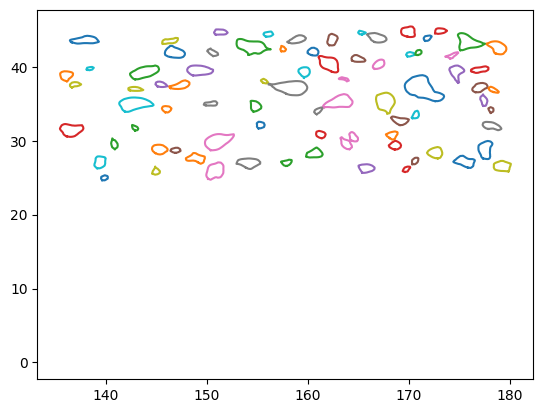

In [131]:
for i in range(len(contour_coordinate_acl)):
    if contour_time_acl[i]==21915:
        print(contour_coordinate_acl[i])
        plt.plot(contour_coordinate_acl[i][0],contour_coordinate_acl[i][1])

## Transform Coordinate into Grid

In [19]:
contour_coordinate_acs=np.load('contour_coordinate_acs.npy')
contour_time_acs=np.load('contour_time_acs.npy')
contour_index_acs=np.load('contour_index_acs.npy')

In [20]:
contour_coordinate_acl=np.load('contour_coordinate_acl.npy')
contour_time_acl=np.load('contour_time_acl.npy')
contour_index_acl=np.load('contour_index_acl.npy')

In [21]:
def point_in_polygon(x, y, poly_x, poly_y):    #判断grid坐标是否位于涡旋边界内部，输入grid lon, grid lat, contour lon, contour lat
    num_vertices = len(poly_x)
    inside = False
    j = num_vertices - 1
    for i in range(num_vertices):
        if ((poly_y[i] > y) != (poly_y[j] > y)) and (x < (poly_x[j] - poly_x[i]) * (y - poly_y[i]) / (poly_y[j] - poly_y[i]) + poly_x[i]):
            inside = not inside
        j = i
    return inside

In [184]:
grid_total=[]

for time in range(21915,25567+1):
    grid_data = np.zeros((len(maplat), len(maplon)))
    for k in range(len(contour_time_acs)):
        if contour_time_acs[k]==time:
            #print(k,time)
            for i in range(len(maplat)):
                for j in range(len(maplon)):
                    if point_in_polygon(maplon[j], maplat[i], contour_coordinate_acs[k][0], contour_coordinate_acs[k][1]):
                        grid_data[i, j] = 1
    
    grid_total.append(grid_data)
    print(k)

25585 21915
25586 21916
25591 21916
25587 21917
25592 21917
25588 21918
25593 21918
25589 21919
25594 21919
25597 21919
25602 21919
25590 21920
25595 21920
25598 21920
25603 21920
25596 21921
25599 21921
25604 21921
25605 21921
25609 21921
25600 21922
25606 21922
25610 21922
25601 21923
25607 21923
25611 21923
25612 21923
25608 21924
25613 21924
25618 21924
25614 21925
25619 21925
25621 21925
25615 21926
25620 21926
25622 21926
25623 21926
25616 21927
25624 21927
25626 21927
25617 21928
25625 21928
25627 21928
25628 21928
25629 21929
25630 21930
25631 21931
25632 21932
25633 21933
25636 21933
25634 21934
25637 21934
25635 21935
25638 21935
25642 21935
25639 21936
25643 21936
25649 21936
25652 21936
25640 21937
25644 21937
25650 21937
25653 21937
25655 21937
25660 21937
25641 21938
25645 21938
25651 21938
25654 21938
25656 21938
25661 21938
25667 21938
25646 21939
25657 21939
25662 21939
25668 21939
25647 21940
25658 21940
25663 21940
25669 21940
25676 21940
25648 21941
25659 21941
2566

29626 22933
29628 22933
29633 22933
29618 22934
29627 22934
29629 22934
29634 22934
29635 22934
29619 22935
29630 22935
29636 22935
29637 22935
29620 22936
29631 22936
29638 22936
29640 22936
29621 22937
29632 22937
29639 22937
29641 22937
29622 22938
29642 22938
29644 22938
29623 22939
29643 22939
29645 22939
29646 22939
29647 22940
29648 22941
29650 22941
29649 22942
29651 22942
29652 22942
29653 22943
29657 22943
29654 22944
29658 22944
29655 22945
29659 22945
29660 22945
29667 22945
29656 22946
29661 22946
29668 22946
29662 22947
29669 22947
29663 22948
29670 22948
29664 22949
29671 22949
29676 22949
29665 22950
29672 22950
29677 22950
29666 22951
29673 22951
29678 22951
29686 22951
29674 22952
29679 22952
29687 22952
29693 22952
29675 22953
29680 22953
29688 22953
29694 22953
29681 22954
29689 22954
29695 22954
29702 22954
29682 22955
29690 22955
29696 22955
29703 22955
29710 22955
29683 22956
29691 22956
29697 22956
29704 22956
29711 22956
29684 22957
29692 22957
29698 22957
2970

30422 23101
30424 23101
30430 23101
30435 23101
30442 23101
30425 23102
30431 23102
30436 23102
30443 23102
30451 23102
30426 23103
30432 23103
30437 23103
30444 23103
30452 23103
30427 23104
30433 23104
30438 23104
30445 23104
30453 23104
30456 23104
30428 23105
30434 23105
30439 23105
30446 23105
30454 23105
30457 23105
30458 23105
30429 23106
30440 23106
30447 23106
30455 23106
30459 23106
30460 23106
30441 23107
30448 23107
30461 23107
30449 23108
30450 23109
30462 23109
30466 23109
30463 23110
30467 23110
30464 23111
30468 23111
30465 23112
30469 23112
30470 23113
30474 23113
30471 23114
30475 23114
30472 23115
30476 23115
30473 23116
30477 23116
30478 23117
30480 23117
30479 23118
30481 23118
30482 23119
30489 23119
30483 23120
30490 23120
30493 23120
30484 23121
30491 23121
30494 23121
30485 23122
30492 23122
30495 23122
30486 23123
30496 23123
30498 23123
30487 23124
30497 23124
30499 23124
30502 23124
30488 23125
30500 23125
30503 23125
30509 23125
30501 23126
30504 23126
3051

31110 23275
31101 23276
31105 23276
31111 23276
31106 23277
31112 23277
31120 23277
31107 23278
31113 23278
31121 23278
31122 23278
31130 23278
31132 23278
31114 23279
31123 23279
31131 23279
31133 23279
31115 23280
31124 23280
31134 23280
31116 23281
31125 23281
31135 23281
31117 23282
31126 23282
31136 23282
31118 23283
31127 23283
31137 23283
31119 23284
31128 23284
31138 23284
31139 23284
31129 23285
31140 23285
31146 23285
31141 23286
31147 23286
31148 23286
31142 23287
31149 23287
31143 23288
31150 23288
31144 23289
31151 23289
31145 23290
31152 23290
31154 23290
31153 23291
31155 23291
31162 23291
31169 23291
31173 23291
31156 23292
31163 23292
31170 23292
31174 23292
31157 23293
31164 23293
31171 23293
31175 23293
31181 23293
31158 23294
31165 23294
31172 23294
31176 23294
31182 23294
31184 23294
31159 23295
31166 23295
31177 23295
31183 23295
31185 23295
31191 23295
31160 23296
31167 23296
31178 23296
31186 23296
31192 23296
31161 23297
31168 23297
31179 23297
31187 23297
3119

31798 23439
31788 23440
31792 23440
31799 23440
31804 23440
31811 23440
31789 23441
31793 23441
31800 23441
31805 23441
31812 23441
31813 23441
31790 23442
31794 23442
31801 23442
31806 23442
31814 23442
31821 23442
31795 23443
31802 23443
31807 23443
31815 23443
31822 23443
31796 23444
31803 23444
31808 23444
31816 23444
31823 23444
31797 23445
31809 23445
31817 23445
31824 23445
31810 23446
31818 23446
31825 23446
31828 23446
31831 23446
31819 23447
31826 23447
31829 23447
31832 23447
31820 23448
31827 23448
31830 23448
31833 23449
31840 23449
31834 23450
31841 23450
31835 23451
31842 23451
31847 23451
31852 23451
31856 23451
31836 23452
31843 23452
31848 23452
31853 23452
31857 23452
31858 23452
31837 23453
31844 23453
31849 23453
31854 23453
31859 23453
31838 23454
31845 23454
31850 23454
31855 23454
31860 23454
31863 23454
31866 23454
31839 23455
31846 23455
31851 23455
31861 23455
31864 23455
31867 23455
31874 23455
31882 23455
31862 23456
31865 23456
31868 23456
31875 23456
3188

32466 23618
32467 23619
32477 23619
32468 23620
32478 23620
32469 23621
32479 23621
32470 23622
32480 23622
32481 23623
32488 23623
32493 23623
32482 23624
32489 23624
32494 23624
32483 23625
32490 23625
32495 23625
32484 23626
32491 23626
32496 23626
32485 23627
32492 23627
32497 23627
32486 23628
32498 23628
32487 23629
32499 23629
32500 23630
32502 23630
32506 23630
32501 23631
32503 23631
32507 23631
32510 23631
32513 23631
32504 23632
32508 23632
32511 23632
32514 23632
32516 23632
32505 23633
32509 23633
32512 23633
32515 23633
32517 23633
32525 23633
32529 23633
32534 23633
32518 23634
32526 23634
32530 23634
32535 23634
32519 23635
32527 23635
32531 23635
32536 23635
32538 23635
32520 23636
32528 23636
32532 23636
32537 23636
32539 23636
32521 23637
32533 23637
32540 23637
32542 23637
32550 23637
32522 23638
32541 23638
32543 23638
32551 23638
32553 23638
32560 23638
32523 23639
32544 23639
32552 23639
32554 23639
32561 23639
32524 23640
32545 23640
32555 23640
32562 23640
3256

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



(34.9, 35.9)

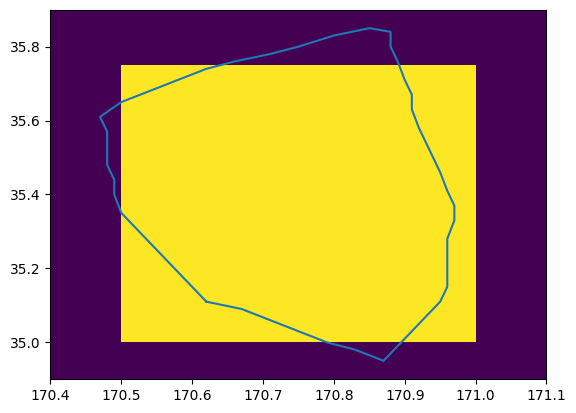

In [202]:
plt.pcolormesh(maplon,maplat,grid_total[1])
plt.plot(contour_coordinate_acs[25585][0],contour_coordinate_acs[25585][1])
plt.xlim(170.4,171.1)
plt.ylim(34.9,35.9)

In [206]:
grid_total=np.array(grid_total)
np.save('grid_acs',grid_total)

In [22]:
grid_total=[]
start_time=tm.time()
for time in range(21915,25567+1):
    grid_data = np.zeros((len(maplat), len(maplon)))
    for k in range(len(contour_time_acl)):
        if contour_time_acl[k]==time:
            #print(k,time)
            for i in range(len(maplat)):
                for j in range(len(maplon)):
                    if point_in_polygon(maplon[j], maplat[i], contour_coordinate_acl[k][0], contour_coordinate_acl[k][1]):
                        grid_data[i, j] = 1
    
    grid_total.append(grid_data)
    end_time=tm.time()
    print(str(time)+', '+str(end_time-start_time)+'s')

21915, 67.89716458320618s
21916, 135.04104614257812s
21917, 201.42425155639648s
21918, 268.6083173751831s
21919, 339.0081980228424s
21920, 408.52835154533386s
21921, 476.43993186950684s
21922, 541.1944835186005s
21923, 607.5400369167328s
21924, 673.056015253067s
21925, 737.7645101547241s
21926, 803.2344193458557s
21927, 870.3839068412781s
21928, 935.9088912010193s
21929, 1002.9970149993896s
21930, 1068.5789189338684s
21931, 1134.075573682785s
21932, 1197.963285446167s
21933, 1263.4616990089417s
21934, 1328.9794046878815s
21935, 1394.4749681949615s
21936, 1459.1786522865295s
21937, 1524.575330734253s
21938, 1588.4690268039703s
21939, 1653.1230864524841s
21940, 1719.4822614192963s
21941, 1785.0210947990417s
21942, 1850.5535871982574s
21943, 1918.5522291660309s
21944, 1984.8187839984894s
21945, 2050.3349874019623s
21946, 2115.8799510002136s
21947, 2181.4665398597717s
21948, 2247.9915783405304s
21949, 2314.4376890659332s
21950, 2379.2468791007996s
21951, 2443.233985185623s
21952, 2503.9710

22225, 20654.602926254272s
22226, 20728.261695623398s
22227, 20801.195691347122s
22228, 20873.991862297058s
22229, 20943.676190137863s
22230, 21010.928716421127s
22231, 21078.931847333908s
22232, 21147.75656247139s
22233, 21216.55105471611s
22234, 21284.65154147148s
22235, 21353.47354030609s
22236, 21423.061074733734s
22237, 21491.935744285583s
22238, 21559.080554246902s
22239, 21625.4760928154s
22240, 21690.197371721268s
22241, 21755.098486423492s
22242, 21820.610196828842s
22243, 21885.384764671326s
22244, 21947.854199886322s
22245, 22010.194988250732s
22246, 22072.55458855629s
22247, 22134.159560203552s
22248, 22196.51516842842s
22249, 22260.51508784294s
22250, 22324.518867492676s
22251, 22388.493552446365s
22252, 22454.14925479889s
22253, 22518.15754699707s
22254, 22582.14965748787s
22255, 22645.380115032196s
22256, 22708.63459944725s
22257, 22772.587026834488s
22258, 22836.561297893524s
22259, 22901.455171346664s
22260, 22967.06084561348s
22261, 23030.977578878403s
22262, 23096.61

22547, 41992.17163062096s
22548, 42046.46546506882s
22549, 42100.82630062103s
22550, 42152.72451591492s
22551, 42204.65201044083s
22552, 42258.26138520241s
22553, 42313.3263092041s
22554, 42370.897545814514s
22555, 42426.81269955635s
22556, 42484.318747997284s
22557, 42542.63756132126s
22558, 42601.77058053017s
22559, 42658.58325600624s
22560, 42715.24824786186s
22561, 42771.144662857056s
22562, 42826.26211595535s
22563, 42882.96504044533s
22564, 42938.1215133667s
22565, 42994.035344839096s
22566, 43049.95947480202s
22567, 43105.916335344315s
22568, 43162.61733150482s
22569, 43219.261644124985s
22570, 43276.78864073753s
22571, 43333.53836250305s
22572, 43391.836151599884s
22573, 43451.0128800869s
22574, 43510.856603860855s
22575, 43572.43701291084s
22576, 43634.093157052994s
22577, 43695.62275624275s
22578, 43757.19115948677s
22579, 43820.29223752022s
22580, 43881.81823706627s
22581, 43943.43844437599s
22582, 44002.52124142647s
22583, 44062.48605513573s
22584, 44121.58515667915s
22585,

22871, 63507.25956654549s
22872, 63573.70660662651s
22873, 63639.28056764603s
22874, 63708.201226472855s
22875, 63777.01930594444s
22876, 63846.65481162071s
22877, 63914.6821410656s
22878, 63983.65103197098s
22879, 64052.50524497032s
22880, 64121.32870030403s
22881, 64189.27583169937s
22882, 64259.00902175903s
22883, 64327.035146951675s
22884, 64393.437544584274s
22885, 64459.07150435448s
22886, 64523.830194950104s
22887, 64588.66115832329s
22888, 64650.98398733139s
22889, 64712.53938245773s
22890, 64773.25217151642s
22891, 64833.13374662399s
22892, 64891.488605737686s
22893, 64951.53100776672s
22894, 65010.713373184204s
22895, 65069.02771282196s
22896, 65127.41231584549s
22897, 65188.17737555504s
22898, 65249.690378427505s
22899, 65311.21149468422s
22900, 65374.38392043114s
22901, 65436.718203783035s
22902, 65497.4715692997s
22903, 65558.25991010666s
22904, 65622.27675533295s
22905, 65685.55112957954s
22906, 65748.80850744247s
22907, 65812.03027701378s
22908, 65875.20877933502s
22909,

23188, 84992.45290350914s
23189, 85050.04666042328s
23190, 85108.51589179039s
23191, 85167.68002176285s
23192, 85230.00644731522s
23193, 85291.58691692352s
23194, 85354.78489971161s
23195, 85417.1804652214s
23196, 85479.52355217934s
23197, 85539.47597789764s
23198, 85599.44156122208s
23199, 85662.61426568031s
23200, 85726.52875828743s
23201, 85789.72366571426s
23202, 85852.85401248932s
23203, 85914.44128775597s
23204, 85979.32406497002s
23205, 86045.780762434s
23206, 86112.25888490677s
23207, 86177.89505910873s
23208, 86244.28466916084s
23209, 86310.61057686806s
23210, 86379.51963067055s
23211, 86445.86426115036s
23212, 86509.71055364609s
23213, 86574.51010107994s
23214, 86638.54028177261s
23215, 86704.94248914719s
23216, 86771.38229608536s
23217, 86837.81903147697s
23218, 86903.46355891228s
23219, 86969.7995018959s
23220, 87033.72588801384s
23221, 87096.84176635742s
23222, 87160.82182335854s
23223, 87221.52700138092s
23224, 87280.66056156158s
23225, 87338.16465997696s
23226, 87392.464

24412, 165784.26836800575s
24413, 165845.82394194603s
24414, 165907.41937732697s
24415, 165968.2341928482s
24416, 166028.9335114956s
24417, 166088.12128806114s
24418, 166146.5116508007s
24419, 166206.46805262566s
24420, 166266.39735102654s
24421, 166327.29887747765s
24422, 166389.8209180832s
24423, 166452.31980514526s
24424, 166516.46084356308s
24425, 166581.4125070572s
24426, 166648.68937516212s
24427, 166716.0017721653s
24428, 166784.9920384884s
24429, 166853.939129591s
24430, 166924.53108477592s
24431, 166995.23154640198s
24432, 167065.02100658417s
24433, 167133.9549651146s
24434, 167203.7329993248s
24435, 167274.3356409073s
24436, 167343.2660021782s
24437, 167409.69600582123s
24438, 167476.25502347946s
24439, 167542.7804992199s
24440, 167609.28704738617s
24441, 167676.6823182106s
24442, 167743.13855528831s
24443, 167810.46586108208s
24444, 167874.66229987144s
24445, 167938.82720661163s
24446, 168003.75374293327s
24447, 168067.87646746635s
24448, 168134.41825556755s
24449, 168204.14

24720, 186491.34468221664s
24721, 186553.8963470459s
24722, 186615.53742098808s
24723, 186678.7501666546s
24724, 186741.19326925278s
24725, 186801.97320604324s
24726, 186861.15371251106s
24727, 186919.53004956245s
24728, 186977.04271006584s
24729, 187034.5623714924s
24730, 187092.18820786476s
24731, 187148.14080953598s
24732, 187204.89736247063s
24733, 187262.48579907417s
24734, 187320.15521359444s
24735, 187379.35797476768s
24736, 187442.65768885612s
24737, 187506.7269961834s
24738, 187572.40167069435s
24739, 187636.5618915558s
24740, 187700.65225052834s
24741, 187765.53853416443s
24742, 187830.44833612442s
24743, 187894.54375100136s
24744, 187957.85839748383s
24745, 188022.71820020676s
24746, 188085.16224336624s
24747, 188148.48025727272s
24748, 188212.55195379257s
24749, 188276.60946130753s
24750, 188339.07713794708s
24751, 188401.52681660652s
24752, 188464.74205112457s
24753, 188527.23954701424s
24754, 188587.23088741302s
24755, 188645.63313508034s
24756, 188704.04120278358s
24757,

25027, 206049.26762223244s
25028, 206113.30443263054s
25029, 206173.9543337822s
25030, 206234.76122140884s
25031, 206294.6850039959s
25032, 206354.58662939072s
25033, 206415.3496313095s
25034, 206478.51307344437s
25035, 206543.31968784332s
25036, 206607.31627821922s
25037, 206670.59919643402s
25038, 206732.9804840088s
25039, 206792.1474585533s
25040, 206851.32871365547s
25041, 206910.41363739967s
25042, 206968.71348524094s
25043, 207027.8645324707s
25044, 207086.22587180138s
25045, 207143.76435732841s
25046, 207200.4485564232s
25047, 207255.5517463684s
25048, 207313.05212402344s
25049, 207370.59208583832s
25050, 207428.16703486443s
25051, 207485.62638139725s
25052, 207544.7467060089s
25053, 207605.51439785957s
25054, 207666.9715771675s
25055, 207727.72768115997s
25056, 207787.7699892521s
25057, 207847.39454388618s
25058, 207910.25041890144s
25059, 207972.79853510857s
25060, 208032.0236377716s
25061, 208091.07668066025s
25062, 208151.74310946465s
25063, 208210.79020166397s
25064, 208268

25335, 226075.0849533081s
25336, 226135.86223602295s
25337, 226196.53160953522s
25338, 226258.86360621452s
25339, 226320.29948830605s
25340, 226384.15602231026s
25341, 226447.3156952858s
25342, 226512.13708543777s
25343, 226576.90971422195s
25344, 226642.45109558105s
25345, 226706.41602420807s
25346, 226771.18754553795s
25347, 226839.16557121277s
25348, 226907.949365139s
25349, 226976.7846953869s
25350, 227044.7195982933s
25351, 227111.81337356567s
25352, 227179.79719471931s
25353, 227247.07037472725s
25354, 227313.57767105103s
25355, 227377.53098392487s
25356, 227441.58345270157s
25357, 227506.4665875435s
25358, 227572.15201330185s
25359, 227639.35845065117s
25360, 227706.73390698433s
25361, 227772.1990056038s
25362, 227839.37892508507s
25363, 227906.60208535194s
25364, 227975.5018041134s
25365, 228044.30089759827s
25366, 228113.1553823948s
25367, 228182.03519535065s
25368, 228251.63119244576s
25369, 228319.59806990623s
25370, 228387.4808139801s
25371, 228454.6883199215s
25372, 228524

In [29]:
grid_total=np.array(grid_total)
np.save('grid_acl',grid_total)